In [81]:
import yaml
import torch
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
import pandas as pd
from omegaconf import OmegaConf
import scanpy as sc

import numpy as np
import IMPA.featurizer.vision_transformer as vits
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pickle as pkl

**Plotting function**

In [2]:
def pca_umap_plot_with_preprocessing(adata, title, batch_name):
    # Set a random seed for reproducibility
    np.random.seed(0)

    # Randomly permute the indices
    random_indices = np.random.permutation(list(range(adata.shape[0])))

    # Set a color palette for better color representation
    sns.set_palette("tab10")

    # Plot the PCA with random reordering
    sc.pl.pca(adata[random_indices, :], color=batch_name, title=title, s=20)

    # Plot the UMAP with random reordering
    sc.pl.umap(adata[random_indices, :], color=batch_name, title=title, s=20)

    # Show the plots
    plt.show()

**Code**

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

From https://github.com/broadinstitute/DINO4Cells_code

In [4]:
path_to_config = "/home/icb/alessandro.palma/environment/IMPA/IMPA/configs/config_dino.yaml"
config = yaml.safe_load(open(path_to_config, "r"))

In [5]:
ckpt_path = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/Cell_Painting_data/DINO_cell_painting_base_checkpoint.pth"

In [6]:
state_dict = torch.load(ckpt_path)

**Load model weights**

In [7]:
config["model"]["arch"]

'vit_base'

In [16]:
model = vits.__dict__[config["model"]["arch"]](
                img_size=[128],
                patch_size=16,
                in_chans=5
            )

embed_dim = model.embed_dim

In [17]:
config["embedding"]["HEAD"] = (
        True if "HEAD" in list(config["embedding"].keys()) else False
    )

In [18]:
embed_dim

768

In [19]:
for p in model.parameters():
    p.requires_grad = False

In [20]:
model.eval()
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(5, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

In [21]:
pretrained_weights = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/Cell_Painting_data/DINO_cell_painting_small_checkpoint.pth"

In [22]:
state_dict = torch.load(pretrained_weights)

In [23]:
if "teacher" in state_dict:
    teacher = state_dict["teacher"]
    if not config["embedding"]["HEAD"] == True:
        teacher = {k.replace("module.", ""): v for k, v in teacher.items()}
        teacher = {
            k.replace("backbone.", ""): v for k, v in teacher.items()
        }
    msg = model.load_state_dict(teacher, strict=False)
else:
    student = state_dict
    if not config["embedding"]["HEAD"] == True:
        student = {k.replace("module.", ""): v for k, v in student.items()}
        student = {
            k.replace("backbone.", ""): v for k, v in student.items()
        }
    student = {k.replace("0.", ""): v for k, v in student.items()}
    msg = model.load_state_dict(student, strict=False)

In [24]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(5, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

**Featurize cells**

In [25]:
img = torch.randn(16, 5, 96, 96).cuda()

In [26]:
feat = model(img)

In [27]:
feat.shape

torch.Size([16, 768])

**Featurize RxRx1 before and after batchn transformation**

In [28]:
args = {
    # TASK NAME
    'task_name': 'rxrx1_batch',

    # IMAGE
    'img_size': 96,
    'latent_dim': 100,
    'hidden_dim': 512,
    'style_dim': 64,
    'stochastic': True,
    'z_dimension': 10,
    'dim_in': 64,
    'pert_modelling': False,
    'batch_key': 'BATCH',
    'subsample_frac': 1.0,

    # LOSS
    'lambda_reg': 1,
    'lambda_cyc': 1,
    'lambda_sty': 1,
    'lambda_ds': 1,

    # TRAINING
    'total_epochs': 100,
    'ds_iter': 100000,
    'resume_iter': 0,
    'batch_size': 32,
    'val_batch_size': 20,
    'lr': 0.0001,
    'f_lr': 0.0001,
    'beta1': 0,
    'beta2': 0.99,
    'weight_decay': 0.0001,
    'num_outs_per_domain': 10,
    'single_style': True,
    'ood_set': None,
    'mol_list': None,
    'balanced': False,
    'trainable_emb': True,
    'dataset_name': 'rxrx1',
    'n_channels': 6,
    'num_workers': 6,
    'seed': 42,

    # DIRECTORIES FOR DATA
    'image_path': '/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/rxrx1',
    'data_index_path': '/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/rxrx1/metadata/rxrx1_df.csv',
    'embedding_path': None,

    # DIRECTORIES FOR RESULTS
    'experiment_directory': '../project_folder/experiments/',
    'sample_dir': 'sample',
    'checkpoint_dir': 'checkpoint',
    'basal_vs_real_folder': 'basal_vs_real',
    'naming_key': 'dataset_name',
    'embedding_folder': 'embeddings',
    'resume_dir': '',

    # DATA HANDLEMENT
    'augment_train': True,
    'normalize': True,

    # LOGGING INFO
    'print_every': 10,
    'sample_every': 1000,
    'save_every': 500,
    'eval_every': 500,

    # PARAMETERS FOR CONDITION ENCODING
    'encode_rdkit': True,
    'num_layers_mapping_net': 1,

    # Lightning
    'filename': 'epoch_{epoch:04d}',
    'monitor': 'fid_transformations',
    'mode': 'min',
    'save_last': True,
    'offline': False,
    'project': 'rxrx1_batch',
    'log_model': False,
    'accelerator': 'gpu',
    'log_every_n_steps': 10
}
args = OmegaConf.create(args)

In [29]:
dataloader = CellDataLoader(args)

In [30]:
dest_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20231220_cbfc860a-2302-457a-b6d9-732d5b776510_rxrx1_batch"

In [31]:
solver = IMPAmodule(args, dest_dir, dataloader)
solver._load_checkpoint(53)

Number of parameters in generator: 24320518
Number of parameters in style_encoder: 14331200
Number of parameters in discriminator: 14299907
Number of parameters in mapping_network: 7104
Initializing embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
Loading checkpoint from /home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20231220_cbfc860a-2302-457a-b6d9-732d5b776510_rxrx1_batch/checkpoint/000053_nets.ckpt...
/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20231220_cbfc860a-2302-457a-b6d9-732d5b776510_rxrx1_batch/checkpoint/000053_nets.ckpt
Loading checkpoint from /home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20231220_cbfc860a-2302-457a-b6d9-732d5b776510_rxrx1_batch/checkpoint/000053_embeddings.ckpt...
/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20231220_cbfc860a-2302-457a-b6d9-732d5b77

In [32]:
train_dataloader = dataloader.train_dataloader()
val_dataloader = dataloader.val_dataloader()

In [36]:
X_before_transf = []
X_after_transf = []

features = {"batch": [],
            "plate": [],
            "well": [],
            "view": [],
            "no": []}

In [37]:
# Transform all with the same random vector. Take the mean 
z_common = torch.randn(1, 100, args.z_dimension).mean(1).cuda()
with torch.no_grad():
    for loader in [train_dataloader, val_dataloader]:
        for batch in tqdm(loader):
            # # Get image 
            X = batch["X"].cuda()
            z = z_common.repeat(X.shape[0], 1)
            # Transport everything to a chosen batch, here we pick 0
            y = 0*torch.ones(X.shape[0]).long().cuda()
            y = solver.embedding_matrix(y).cuda()
            y = torch.cat([y, z], dim=1)
            y = solver.nets.mapping_network(y)
            # Transport image to new batch
            _, X_generated = solver.nets.generator(X, y)
            for i, filename in enumerate(batch["file_names"]):
                batch, plate, well, view, no = filename.split("-")[1].split("_")
                features["batch"].append(batch)
                features["plate"].append(plate)
                features["well"].append(well)
                features["view"].append(view)
                features["no"].append(no)

            Z_before_transf = model(X[:, :-1, :, :])
            Z_after_transf = model(X_generated[:, :-1, :, :])

            X_before_transf.append(Z_before_transf.detach().cpu())
            X_after_transf.append(Z_after_transf.detach().cpu())

100%|██████████| 1714/1714 [01:50<00:00, 15.56it/s]


In [38]:
X_before_transf = torch.cat(X_before_transf, dim=0)
X_after_transf = torch.cat(X_after_transf, dim=0)

In [39]:
adata_before_transf = sc.AnnData(X=X_before_transf.detach().cpu().numpy(), 
                                 obs= pd.DataFrame(features))
adata_after_transf = sc.AnnData(X=X_after_transf.detach().cpu().numpy(), 
                                 obs= pd.DataFrame(features))

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Before correction

In [40]:
sc.tl.pca(adata_before_transf)
sc.pp.neighbors(adata_before_transf)
sc.tl.umap(adata_before_transf)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


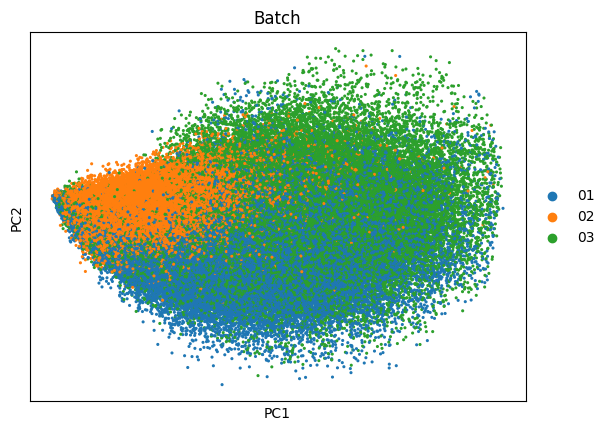

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


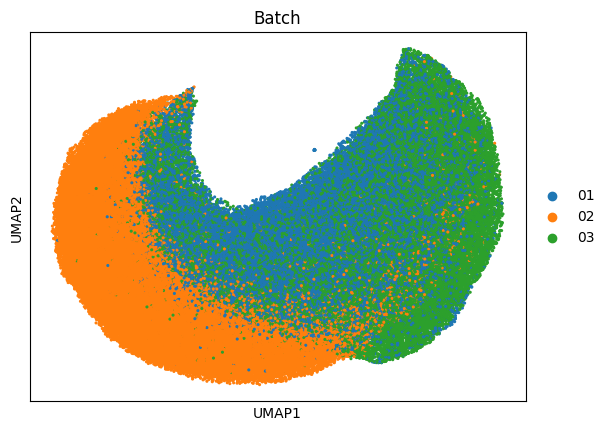

In [50]:
pca_umap_plot_with_preprocessing(adata_before_transf, "Batch", "batch")

After correction

In [42]:
sc.tl.pca(adata_after_transf)
sc.pp.neighbors(adata_after_transf)
sc.tl.umap(adata_after_transf)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


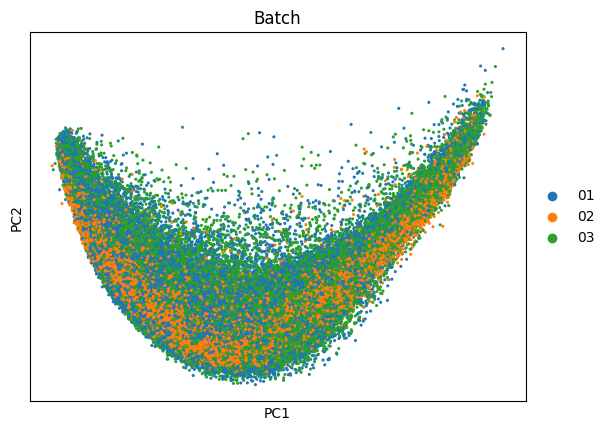

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


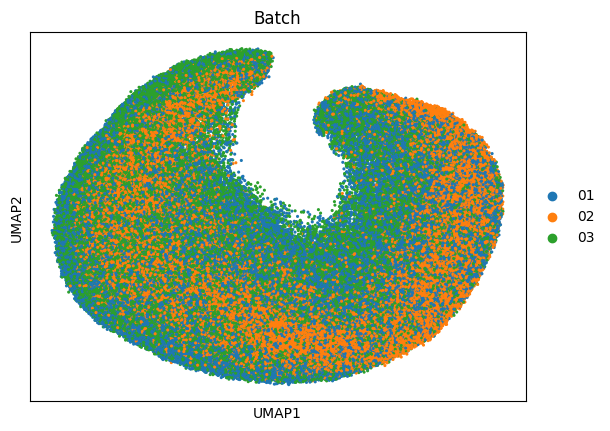

In [49]:
pca_umap_plot_with_preprocessing(adata_after_transf, "Batch", "batch")

Save results

In [51]:
feature_dest_folder = Path("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/featurized_anndata")

In [52]:
# adata_before_transf.write_h5ad(feature_dest_folder / "rxrx1_adata_before_transf.h5ad")

In [53]:
# adata_after_transf.write_h5ad(feature_dest_folder / "rxrx1_adata_after_transf.h5ad")

## Add compounds to anndata

In [47]:
data_index = pd.read_csv('/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/rxrx1/metadata/rxrx1_df.csv', index_col=1)
data_index

,Unnamed: 0,BATCH,PLATE,WELL,VIEW,CPD_NAME,ANNOT,CELL_LINE,DOSE,SPLIT
SAMPLE_KEY,,,,,,,,,,
U2OS-01_1_B02_s1_14,0,U2OS-01,1,B02,s1,UNTREATED,negative_control,U2OS,NaN,train
U2OS-01_1_B02_s1_15,1,U2OS-01,1,B02,s1,UNTREATED,negative_control,U2OS,NaN,train
U2OS-01_1_B02_s1_16,2,U2OS-01,1,B02,s1,UNTREATED,negative_control,U2OS,NaN,train
U2OS-01_1_B02_s1_17,3,U2OS-01,1,B02,s1,UNTREATED,negative_control,U2OS,NaN,test
U2OS-01_1_B02_s1_19,4,U2OS-01,1,B02,s1,UNTREATED,negative_control,U2OS,NaN,train
...,...,...,...,...,...,...,...,...,...,...
U2OS-03_3_O23_s2_8,181260,U2OS-03,3,O23,s2,TSFM,treated,U2OS,NaN,train
U2OS-03_3_O23_s2_9,181261,U2OS-03,3,O23,s2,TSFM,treated,U2OS,NaN,test
U2OS-03_3_O23_s2_10,181262,U2OS-03,3,O23,s2,TSFM,treated,U2OS,NaN,train


In [62]:
compound_names = []

for row in adata_before_transf.obs.iterrows():
    batch = row[1].batch
    plate = row[1].plate
    well = row[1].well
    view = row[1]["view"]
    no = row[1].no
    file_name = f"U2OS-{batch}_{plate}_{well}_{view}_{no}"
    cpd = data_index.loc[file_name].CPD_NAME
    compound_names.append(cpd)

In [70]:
adata_before_transf.obs["compound"] = compound_names

In [71]:
adata_after_transf.obs["compound"] = compound_names

## Evaluate scib metrics

In [72]:
adata_unique = adata_before_transf.copy()

In [73]:
adata_unique.obsm["Unintegrated"] = adata_before_transf.obsm["X_pca"]

In [74]:
adata_unique.obsm["IMPA-Integrated"] = adata_after_transf.obsm["X_pca"]

In [75]:
adata_unique

AnnData object with n_obs × n_vars = 170942 × 768
    obs: 'batch', 'plate', 'well', 'view', 'no', 'compound'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'Unintegrated', 'IMPA-Integrated'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [76]:
from scib_metrics.benchmark import Benchmarker

In [ ]:
bm = Benchmarker(
    adata_unique,
    batch_key="batch",
    label_key="compound",
    embedding_obsm_keys=["Unintegrated", "IMPA-Integrated"],
    n_jobs=6,
)
bm.benchmark()

Computing neighbors:  50%|█████     | 1/2 [01:31<01:31, 91.43s/it]

In [ ]:
scib_path = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/scib/rxrx1.pkl"

In [ ]:
with open(scib_path, "wb") as file:
    pkl.dump(bm, file)

In [84]:
# with open(scib_path, "rb") as file:
#     b = pkl.load(file)